In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore, median_abs_deviation
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Acquisition

In [ ]:
# Load the dataset with the correct encoding and delimiter
df = pd.read_csv('small_businesses_enhanced1.csv', encoding='ISO-8859-1', delimiter=';')

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display the column names
print("\nColumn names:")
print(df.columns)

First 5 rows of the dataset:
               Business Name                            Business Description  \
0               Davidson LLC                        Balanced 24/7 throughput   
1                 Hill Group                   Networked background database   
2  Flowers, Benson and Mejia       Multi-lateral multi-tasking knowledgebase   
3  Phillips, Ho and Williams         Centralized context-sensitive moderator   
4                Johnson PLC  Programmable object-oriented Internet solution   

                                             Address         Industry  \
0              62377 Brown Camp, Jerryport, OH 80139  Food & Beverage   
1             4913 Cook Road, Gregorymouth, ME 19106          Fashion   
2    855 Fisher Canyon Apt. 341, Taylorton, NJ 19828           Health   
3  79465 Ramirez Mountains, North Maryport, MD 34794           Health   
4  83752 Christopher Way Apt. 894, North Joseph, ...           Health   

         Target Customer Customer Age Range        

# 2. Data Understanding

**2.1 Inspect Dataset Structure**

In [ ]:
# Check the shape of the dataset
print("Dataset shape:", df.shape)

# Check data types of each column
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset shape: (5000, 15)

Data types:
Business Name                object
Business Description         object
Address                      object
Industry                     object
Target Customer              object
Customer Age Range           object
Customer Country             object
Marketing Budget             object
Website                      object
Social Media                 object
Product Image URL            object
Product Description          object
Final Product Description    object
Company_Scrap_Data           object
Product_Scrap_Data           object
dtype: object

Missing values in each column:
Business Name                0
Business Description         0
Address                      0
Industry                     0
Target Customer              0
Customer Age Range           0
Customer Country             0
Marketing Budget             0
Website                      0
Social Media                 0
Product Image URL            0
Product Description          0
Fin

**# 2.2 Select Relevant Features**

In [ ]:
# Select only the relevant features for analysis
relevant_features = [
    'Industry', 'Target Customer', 'Customer Age Range',
    'Marketing Budget'
]

# Create a new DataFrame with only the relevant features
df_relevant = df[relevant_features]

# Display the first few rows of the relevant DataFrame
print("\nFirst 5 rows of the relevant DataFrame:")
print(df_relevant.head())


First 5 rows of the relevant DataFrame:
          Industry        Target Customer Customer Age Range Marketing Budget
0  Food & Beverage        Startups et PME          25-50 ans          45255 
1          Fashion  Jeunes professionnels          25-50 ans          41227 
2           Health  Jeunes professionnels          18-35 ans          30755 
3           Health  Jeunes professionnels          25-50 ans          35093 
4           Health        Startups et PME          18-35 ans          40319 


# 3. Data Preparation

**3.1 Handle Missing Values**

In [ ]:
# Drop rows with missing values
df_relevant = df_relevant.dropna()

# Verify that there are no missing values
print("\nMissing values after dropping:")
print(df_relevant.isnull().sum())


Missing values after dropping:
Industry              0
Target Customer       0
Customer Age Range    0
Marketing Budget      0
dtype: int64


**3.2 Clean the Marketing Budget Column**

In [ ]:
# Clean the Marketing Budget column
df_relevant['Marketing Budget'] = (
    df_relevant['Marketing Budget']
    .str.replace('', '', regex=False)  # Remove the Euro symbol
    .str.replace(',', '', regex=False)  # Remove commas (if any)
    .astype(float)  # Convert to numeric type
)

# Display the cleaned Marketing Budget column
print("\nCleaned Marketing Budget column:")
print(df_relevant['Marketing Budget'].head())


Cleaned Marketing Budget column:
0    45255.0
1    41227.0
2    30755.0
3    35093.0
4    40319.0
Name: Marketing Budget, dtype: float64


**3.3 Add Trends and Strategy Category Columns**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Expanded trend mappings including all industries and more features
trend_mappings = {
    "Food & Beverage": {
        "18-35 ans": {
            "Jeunes professionnels": ["Healthy snacks, plant-based diets", "Cold-pressed juices, superfoods"],
            "Startups et PME": ["Organic living, self-care", "Sustainable packaging"]
        },
        "25-50 ans": {
            "Jeunes professionnels": ["Meal kits, premium beverages", "Wine tasting experiences"],
            "Startups et PME": ["Gourmet cooking classes", "Farm-to-table experiences"]
        }
    },
    "Fashion": {
        "18-35 ans": {
            "Jeunes professionnels": ["Athleisure, sustainability", "Streetwear, eco-friendly fashion"],
            "Startups et PME": ["Minimalist fashion, capsule wardrobes", "Upcycled clothing"]
        },
        "25-50 ans": {
            "Jeunes professionnels": ["Luxury fashion, timeless styles", "Experiential fashion shows"],
            "Startups et PME": ["Pet wellness fashion", "Ethical luxury brands"]
        }
    },
    "Health": {
        "18-35 ans": {
            "Jeunes professionnels": ["Fitness trackers, mental health apps", "Yoga, meditation retreats"],
            "Startups et PME": ["Mobile apps, remote health tools", "Telehealth solutions"]
        },
        "25-50 ans": {
            "Jeunes professionnels": ["Wellness retreats, personalized healthcare", "Virtual health events"],
            "Startups et PME": ["Sustainable healthcare products", "Corporate wellness programs"]
        }
    },
    "Tech": {  # Updated to match dataset's "Tech" industry
        "18-35 ans": {
            "Jeunes professionnels": ["Gaming, AR/VR experiences", "Social media platforms, content creation"],
            "Startups et PME": ["Smart home devices, IoT", "AI-driven startups"]
        },
        "25-50 ans": {
            "Jeunes professionnels": ["Productivity tools, automation", "Cybersecurity, data privacy"],
            "Startups et PME": ["Smart home solutions", "Enterprise AI solutions"]
        }
    },
    "Education": {
        "18-35 ans": {
            "Jeunes professionnels": ["Online courses, skill development", "Coding bootcamps, tech certifications"],
            "Startups et PME": ["Language learning apps", "EdTech platforms"]
        },
        "25-50 ans": {
            "Jeunes professionnels": ["Professional certifications, executive education", "Online MBA programs"],
            "Startups et PME": ["Leadership training, soft skills", "Career coaching platforms"]
        }
    }
}

def assign_trend(row):
    industry = row['Industry']
    age_range = row['Customer Age Range']
    target_customer = row['Target Customer']

    # Check if industry, age range, and target customer exist in mappings
    if industry in trend_mappings:
        if age_range in trend_mappings[industry]:
            if target_customer in trend_mappings[industry][age_range]:
                # Deterministic selection: choose the first trend for consistency
                return trend_mappings[industry][age_range][target_customer][0]

    # Default trend based on industry or generic fallback
    default_trends = {
        "Food & Beverage": "Sustainable food practices",
        "Fashion": "Eco-friendly fashion",
        "Health": "Digital health solutions",
        "Tech": "AI-driven innovations",
        "Education": "Online learning platforms",
        "Other": "Sustainability, local sourcing"
    }
    return default_trends.get(industry, default_trends["Other"])

# Apply trend assignment
df_relevant['Trends'] = df_relevant.apply(assign_trend, axis=1)


# Calculate industry-specific budget thresholds
budget_thresholds = df_relevant.groupby('Industry')['Marketing Budget'].quantile([0.33, 0.66]).unstack()
budget_thresholds.columns = ['Low_Medium', 'Medium_High']

# Expanded strategy mappings
strategy_mappings = {
    "Food & Beverage": {
        "Low Budget": {
            "18-35 ans": "Social Media Marketing",
            "25-50 ans": "Email Marketing"
        },
        "Medium Budget": {
            "18-35 ans": "Content Marketing",
            "25-50 ans": "Search Engine Optimization (SEO)"
        },
        "High Budget": {
            "18-35 ans": "Influencer Marketing",
            "25-50 ans": "Event Marketing"
        }
    },
    "Fashion": {
        "Low Budget": {
            "18-35 ans": "Social Media Marketing",
            "25-50 ans": "Email Marketing"
        },
        "Medium Budget": {
            "18-35 ans": "Influencer Marketing",
            "25-50 ans": "Content Marketing"
        },
        "High Budget": {
            "18-35 ans": "Pay-Per-Click (PPC) Advertising",
            "25-50 ans": "Event Marketing"
        }
    },
    "Health": {
        "Low Budget": {
            "18-35 ans": "Social Media Marketing",
            "25-50 ans": "Content Marketing"
        },
        "Medium Budget": {
            "18-35 ans": "Search Engine Optimization (SEO)",
            "25-50 ans": "Email Marketing"
        },
        "High Budget": {
            "18-35 ans": "Pay-Per-Click (PPC) Advertising",
            "25-50 ans": "Event Marketing"
        }
    },
    "Tech": {
        "Low Budget": {
            "18-35 ans": "Content Marketing",
            "25-50 ans": "Email Marketing"
        },
        "Medium Budget": {
            "18-35 ans": "Search Engine Optimization (SEO)",
            "25-50 ans": "Content Marketing"
        },
        "High Budget": {
            "18-35 ans": "Pay-Per-Click (PPC) Advertising",
            "25-50 ans": "Event Marketing"
        }
    },
    "Education": {
        "Low Budget": {
            "18-35 ans": "Social Media Marketing",
            "25-50 ans": "Email Marketing"
        },
        "Medium Budget": {
            "18-35 ans": "Content Marketing",
            "25-50 ans": "Search Engine Optimization (SEO)"
        },
        "High Budget": {
            "18-35 ans": "Pay-Per-Click (PPC) Advertising",
            "25-50 ans": "Event Marketing"
        }
    }
}

def assign_strategy(row):
    industry = row['Industry']
    budget = row['Marketing Budget']
    age_range = row['Customer Age Range']

    # Get industry-specific budget thresholds
    if industry in budget_thresholds.index:
        low_medium = budget_thresholds.loc[industry, 'Low_Medium']
        medium_high = budget_thresholds.loc[industry, 'Medium_High']
    else:
        low_medium, medium_high = 30000, 40000  # Fallback thresholds

    # Categorize budget
    if budget < low_medium:
        budget_category = "Low Budget"
    elif low_medium <= budget <= medium_high:
        budget_category = "Medium Budget"
    else:
        budget_category = "High Budget"

    # Assign strategy
    if industry in strategy_mappings:
        if budget_category in strategy_mappings[industry]:
            if age_range in strategy_mappings[industry][budget_category]:
                return strategy_mappings[industry][budget_category][age_range]

    # Default strategy based on industry
    default_strategies = {
        "Food & Beverage": "Content Marketing",
        "Fashion": "Social Media Marketing",
        "Health": "Search Engine Optimization (SEO)",
        "Tech": "Pay-Per-Click (PPC) Advertising",
        "Education": "Email Marketing",
        "Other": "Content Marketing"
    }
    return default_strategies.get(industry, default_strategies["Other"])

# Apply strategy assignment
df_relevant['Strategy Category'] = df_relevant.apply(assign_strategy, axis=1)


# Save the updated dataset
df_relevant.to_csv('small_businesses_with_trends_and_strategy.csv', index=False)

print("Updated DataFrame with Strategy Category (first 5 rows):")
print(df_relevant.head())
print("Dataset saved successfully!")

Updated DataFrame with Strategy Category (first 5 rows):
          Industry        Target Customer Customer Age Range  \
0  Food & Beverage        Startups et PME          25-50 ans   
1          Fashion  Jeunes professionnels          25-50 ans   
2           Health  Jeunes professionnels          18-35 ans   
3           Health  Jeunes professionnels          25-50 ans   
4           Health        Startups et PME          18-35 ans   

   Marketing Budget                                      Trends  \
0           45255.0                     Gourmet cooking classes   
1           41227.0             Luxury fashion, timeless styles   
2           30755.0        Fitness trackers, mental health apps   
3           35093.0  Wellness retreats, personalized healthcare   
4           40319.0            Mobile apps, remote health tools   

                  Strategy Category  
0                   Event Marketing  
1                   Event Marketing  
2  Search Engine Optimization (SEO)  
3  

**3.4 Encode Categorical Variables**

In [ ]:
# Encode Strategy Category (target) with LabelEncoder and store for decoding
strategy_encoder = LabelEncoder()
df_relevant['Strategy Category'] = strategy_encoder.fit_transform(df_relevant['Strategy Category'])

# Label encode categorical features
categorical_columns = ['Industry', 'Target Customer', 'Customer Age Range', 'Trends']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_relevant[col] = le.fit_transform(df_relevant[col].astype(str))
    label_encoders[col] = le  # Save encoder for potential inverse transform

**3.5 Detect and Handle Outliers**

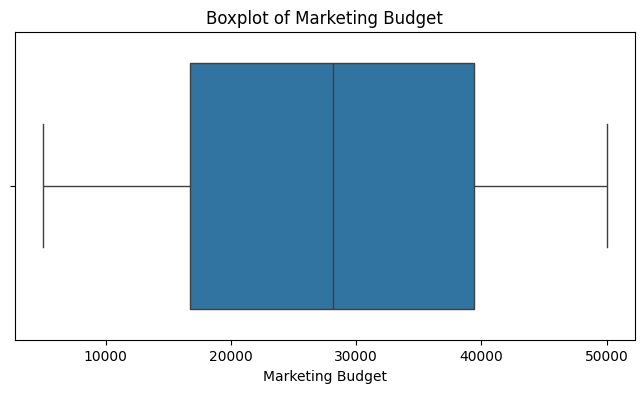

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Ensure deep copy
df_relevant = df_relevant.copy()

# Boxplot for Marketing Budget
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_relevant['Marketing Budget'])
plt.title("Boxplot of Marketing Budget")
plt.show()

**3.9 Train-Test Split**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Ensure df_relevant is a deep copy to avoid SettingWithCopyWarning
df_relevant = df_relevant.copy()

# Prepare features and target
X = df_relevant.drop(columns=['Strategy Category'])
y = df_relevant['Strategy Category']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
# Check class distribution before SMOTE
print("\nClass distribution in y_train before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nClass distribution in y_train after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Verify new training set shape
print("\nResampled training set shape:", X_train_resampled.shape)



Training set shape: (4000, 5)
Testing set shape: (1000, 5)

Class distribution in y_train before SMOTE:
Strategy Category
0    816
1    706
6    621
4    604
5    602
2    469
3    182
Name: count, dtype: int64

Class distribution in y_train after SMOTE:
Strategy Category
1    816
4    816
6    816
2    816
5    816
0    816
3    816
Name: count, dtype: int64

Resampled training set shape: (5712, 5)


# 4- Modeling

**Hyperparameter Tuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees
    'max_depth': [None, 10, 20],      # Depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
}

# Perform Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


**Compare Multiple Models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(**grid_search.best_params_, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.4150
Random Forest Accuracy: 0.9930


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9910


**Train the Best Model**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier with the best parameters
best_model = xgb.XGBClassifier(**grid_search.best_params_)

# Train the model
best_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

# 5- Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Make Predictions
y_pred = best_model.predict(X_test)

# Print Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       204
           1       1.00      0.98      0.99       176
           2       0.97      1.00      0.99       117
           3       1.00      1.00      1.00        46
           4       0.98      0.99      0.99       151
           5       0.99      0.97      0.98       151
           6       1.00      0.99      1.00       155

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Confusion Matrix:
 [[204   0   0   0   0   0   0]
 [  2 172   2   0   0   0   0]
 [  0   0 117   0   0   0   0]
 [  0   0   0  46   0   0   0]
 [  0   0   0   0 150   1   0]
 [  0   0   1   0   3 147   0]
 [  0   0   0   0   0   1 154]]


In [ ]:
from sklearn.metrics import accuracy_score

# Assume best_model is the trained XGBoost model from GridSearchCV
# X_train_selected, X_test_selected, y_train_resampled, y_test are available

# Compute training and test accuracy
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"\nTraining Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Accuracy Gap (Training - Test): {(train_accuracy - test_accuracy):.3f}")


Training Accuracy: 0.999
Test Accuracy: 0.990
Accuracy Gap (Training - Test): 0.009


**Test on New Data**

In [ ]:
# Convert predictions back to original categories
predicted_categories = strategy_encoder.inverse_transform(y_pred)  # De-encode the whole array


# Test on a new sample and de-encode
new_sample = X_test.iloc[0].values.reshape(1, -1)
predicted_category = best_model.predict(new_sample)
predicted_category_decoded = strategy_encoder.inverse_transform(predicted_category)

print("Predicted Strategy Category for the new sample:", predicted_category_decoded[0])

Predicted Strategy Category for the new sample: Social Media Marketing


In [ ]:
import xgboost as xgb
import pickle

# Assuming best_model is your trained XGBClassifier from FinalML.ipynb
# Save the XGBoost model to a file
best_model.save_model('xgboost_strategy_model.json')
# Save the strategy_encoder (LabelEncoder for Strategy Category)
with open('strategy_encoder.pkl', 'wb') as f:
    pickle.dump(strategy_encoder, f)

# Save the label_encoders (dictionary of LabelEncoder for features)
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Model and encoders saved successfully!")

Model and encoders saved successfully!
